Fetching data from: https://www.waterrights.utah.gov/dvrtdb/daily-chart.asp?station_id=6&end_date=2025-04-18&f=json


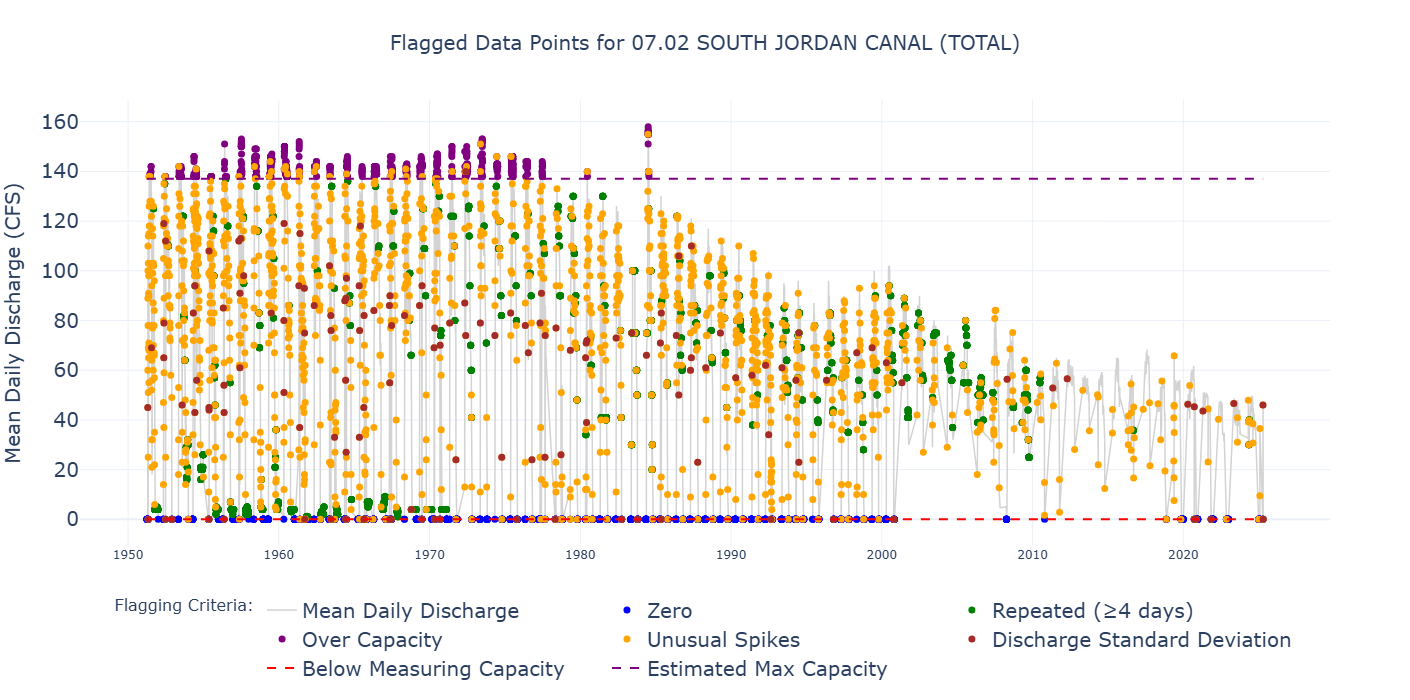

Fetching data from: https://www.waterrights.utah.gov/dvrtdb/daily-chart.asp?station_id=18&end_date=2025-04-18&f=json


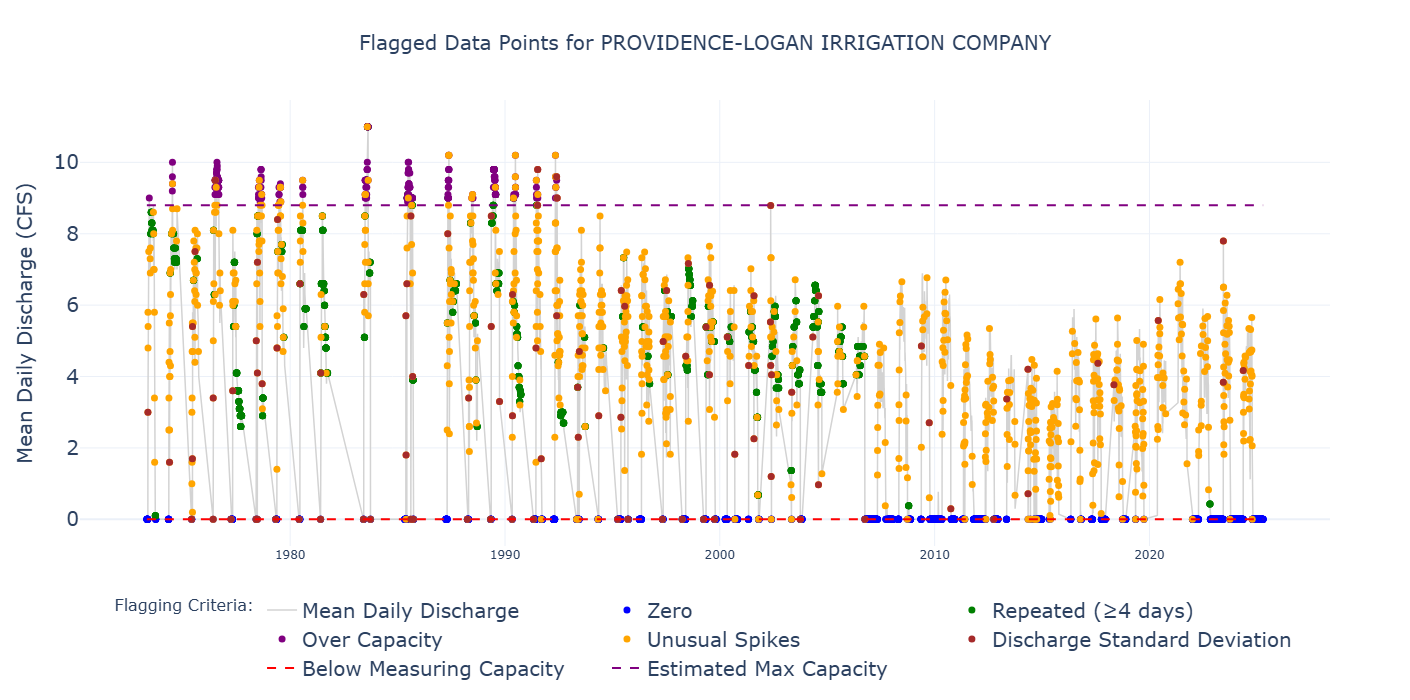

Fetching data from: https://www.waterrights.utah.gov/dvrtdb/daily-chart.asp?station_id=19&end_date=2025-04-18&f=json


Fetching data from: https://www.waterrights.utah.gov/dvrtdb/daily-chart.asp?station_id=21&end_date=2025-04-18&f=json


Fetching data from: https://www.waterrights.utah.gov/dvrtdb/daily-chart.asp?station_id=26&end_date=2025-04-18&f=json


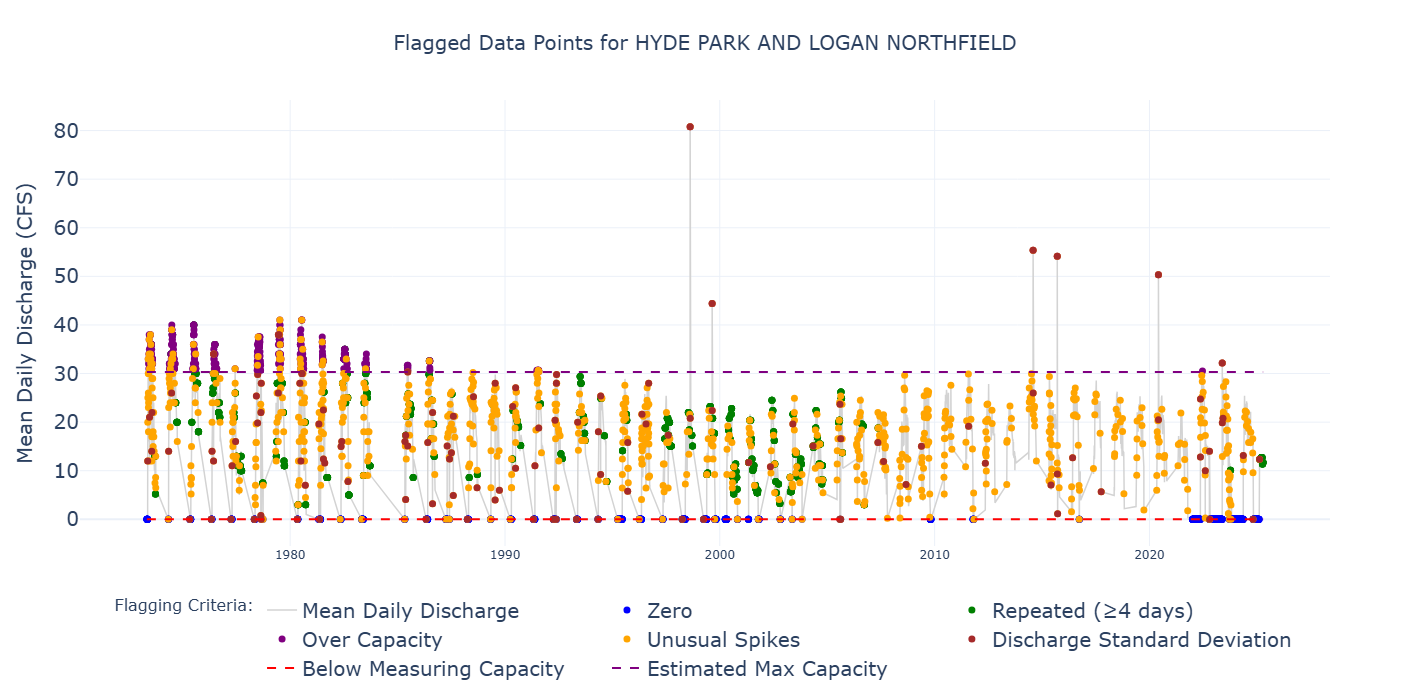

In [6]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.graph_objects as go

# === Load Thresholds CSV === #
thresholds_df = pd.read_csv("dvrt_data_qualifiers_max_min_RoC_SD_table.csv")  # Make sure this file is in the same directory

# === Load site IDs from metadata CSV === #
metadata_path = "meta_data_for_all_active_systems_for_calculation_table_20250401.csv"
metadata_df = pd.read_csv(metadata_path, dtype=str)
site_ids = metadata_df["STATION_ID"].head(5).tolist()

# === Loop through each site === #
for DivrtID in site_ids:
    end_date = datetime.today().strftime("%Y-%m-%d")
    api_url = f"https://www.waterrights.utah.gov/dvrtdb/daily-chart.asp?station_id={DivrtID}&end_date={end_date}&f=json"
    print(f"Fetching data from: {api_url}")

    response = requests.get(api_url)
    if response.status_code != 200:
        print(f"Error fetching data for {DivrtID}: {response.status_code}")
        continue

    data = response.json()
    if "data" not in data:
        print(f"No data returned for site {DivrtID}")
        continue

    # Create DataFrame
    df = pd.DataFrame(data["data"], columns=["date", "value"])
    df.rename(columns={"date": "Date", "value": "DISCHARGE"}, inplace=True)
    df["Date"] = pd.to_datetime(df["Date"])
    df["DISCHARGE"] = pd.to_numeric(df["DISCHARGE"], errors="coerce")

    # Add metadata
    metadata_fields = ["station_id", "station_name", "system_name", "units"]
    metadata = {field: data.get(field, "N/A") for field in metadata_fields}
    for key, value in metadata.items():
        df[key] = value

    df = df[["Date", "DISCHARGE"] + metadata_fields]

    # === Get Thresholds === #
    site_thresholds = thresholds_df[thresholds_df["SiteID"].astype(str) == DivrtID]
    if site_thresholds.empty:
        print(f"No thresholds found for SiteID {DivrtID}. Skipping.")
        continue

    min_val = 0  # Static minimum from your earlier script
    max_val = site_thresholds["Over_Capacity"].values[0]
    spike_unusual = site_thresholds["Unsual_Spike"].values[0]
    std_discharge = site_thresholds["Discharge_Standard_Deviation"].values[0]

    # === Flagging Logic === #
    df['FLAG_LESS_THAN_Min._Value'] = (df['DISCHARGE'] < min_val) & (df['DISCHARGE'] != 0)
    df['FLAG_ZERO'] = (df['DISCHARGE'] == 0)
    df['FLAG_GREATER_THAN_MaxValue'] = (df['DISCHARGE'] > max_val)

    # Flag negative values as Below Capacity
    df['FLAG_BELOW_CAPACITY'] = df['DISCHARGE'] < 0

    df['RATE_OF_CHANGE'] = df['DISCHARGE'].diff().abs()
    df['UNUSUAL_SPIKE'] = df['RATE_OF_CHANGE'] > spike_unusual
    df['FLAG_DISCHARGE_CHANGE'] = df['RATE_OF_CHANGE'] > std_discharge

    df['FLAG_REPEATED'] = (
        df['DISCHARGE']
        .where(df['DISCHARGE'] != 0)
        .groupby((df['DISCHARGE'] != df['DISCHARGE'].shift()).cumsum())
        .transform('count') >= 4
    )

    df['FLAGGED'] = df[
        [
            'FLAG_LESS_THAN_Min._Value',
            'FLAG_ZERO',
            'FLAG_REPEATED',
            'FLAG_GREATER_THAN_MaxValue',
            'UNUSUAL_SPIKE',
            'FLAG_DISCHARGE_CHANGE',
            'FLAG_BELOW_CAPACITY'
        ]
    ].any(axis=1)

    # === Plotting === #
    plot_title = f"Flagged Data Points for {metadata.get('station_name', 'Station ' + DivrtID)}"
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['DISCHARGE'],
        mode='lines',
        line=dict(color='lightgray', width=1.5),
        name='Mean Daily Discharge',
        connectgaps=False
    ))

    # Flag color map
    flag_colors = {
        'FLAG_ZERO': ('blue', 'Zero'),
        'FLAG_REPEATED': ('green', 'Repeated (≥4 days)'),
        'FLAG_GREATER_THAN_MaxValue': ('purple', 'Over Capacity'),
        'UNUSUAL_SPIKE': ('orange', 'Unusual Spikes'),
        'FLAG_DISCHARGE_CHANGE': ('brown', 'Discharge Standard Deviation'),
        'FLAG_BELOW_CAPACITY': ('red', 'Below Capacity (Negative Values)')  # Added for Below Capacity
    }

    for flag, (color, label) in flag_colors.items():
        subset = df[df[flag]]
        if not subset.empty:
            fig.add_trace(go.Scatter(
                x=subset['Date'], y=subset['DISCHARGE'],
                mode='markers',
                marker=dict(color=color, size=7),
                name=label
            ))

    # Horizontal threshold lines
    fig.add_trace(go.Scatter(
        x=[df['Date'].min(), df['Date'].max()],
        y=[min_val, min_val],
        mode='lines',
        line=dict(color="red", dash="dash"),
        name="Below Measuring Capacity"
    ))
    fig.add_trace(go.Scatter(
        x=[df['Date'].min(), df['Date'].max()],
        y=[max_val, max_val],
        mode='lines',
        line=dict(color="purple", dash="dash"),
        name="Estimated Max Capacity"
    ))

    fig.update_layout(
        title=dict(text=plot_title, x=0.5, font=dict(size=20)),
        yaxis=dict(title="Mean Daily Discharge (CFS)", title_font=dict(size=20), tickfont=dict(size=20)),
        legend=dict(
            orientation="h",
            yanchor="top",
            y=-0.1,
            xanchor="center",
            x=0.5,
            title=dict(text="Flagging Criteria:", font=dict(size=16)),
            font=dict(size=20)
        ),
        template="plotly_white",
        width=1400,
        height=700
    )

    fig.show()